In [104]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, exposure, data, img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask, threshold_otsu, threshold_local
from skimage.transform import rescale

### Boost contrast

_Converts color image to high contrast black and white_

Steps involved
1. Convert image to grayscale
2. Adjust gamma and sigmoid, rescale intensity and sharpen image (as required)
3. Perform *local thresholding*, to convert grayscale image to black and white with balanced intensity
4. Save as png if required

In [105]:
def boostContrast(fname, image):

    grayscale_img = rgb2gray(image)
    grayscale_img = exposure.adjust_gamma(grayscale_img, 3)
    grayscale_img = exposure.adjust_sigmoid(grayscale_img,1,3)
    grayscale_img = exposure.rescale_intensity(grayscale_img)
    grayscale_img = unsharp_mask(grayscale_img, radius=5, amount=1)
    local_thresh = threshold_local(grayscale_img, 35)
    binary_local = grayscale_img > local_thresh

    io.imsave(fname,img_as_ubyte(binary_local))
    return binary_local



### Find fibre count

_Counts the number of black-white transitions_

Steps
1. Convert image array to a 2D matrix
2. Count number of transitions between black and white pixels per row
3. Find the average of all transition counts

In [106]:
def findFibreCount(img_arr, block_size):
        fibreCount = []
        transitionCount = 0
        currentState = 0

        for row in img_arr:
                counter = 0
                for col in row:
                        if col == 0
                                counter += 1
        
                fibreCount.append(counter)

        transitionCount = sum(fibreCount)/len(fibreCount)

        return transitionCount

In [107]:
def getImageArr(filename):
    try:
        processed_image = io.imread(filename)
    except:
        return []

    return np.reshape(processed_image.flatten(), processed_image.shape)

In [108]:
def newDir(dirname):
    dirname += '_'
    num = 1
    while os.path.exists(dirname + str(num)):
        num += 1
    dirname = dirname + str(num)
    os.mkdir(dirname)
    return dirname

### Fabric diagnosis

_Downscale image at intervals and count fibres_

1. Perform boost contrast over image
2. Downscale the contrast-boosted image by factors of 0.95,0.85,0.75....0.15,0.05
3. Perform boost contrast for downscaled image (to convert to black and white)
4. Find fibre count for each downscaled image. Store all values in array

In [109]:
def fabricDiagnosis(fname, block_size=1):
    try:
        full_img = boostContrast('Scratch/temp.png',io.imread(fname))
    except:
        return []
    block_size_arr = [i/100 for i in range(5,100,10)]
    fibre_count_arr = []
    dirname = newDir('output_images') + '/'
    for i in block_size_arr:
        img = rescale(full_img,scale=i)
        local_thresh = threshold_local(img, 35)
        binary_local = img > local_thresh
        #print(findFibreCount(binary_local,1))
        img_arr = np.reshape(binary_local.flatten(), binary_local.shape)
        fibre_count_arr.append(findFibreCount(img_arr=binary_local, block_size=block_size))

        tfname = 'compressed_img_' + str(i) + '.png'

        io.imsave(dirname + tfname, img_as_ubyte(binary_local))

    # for block_size, fibre_count in zip(block_size_arr,fibre_count_arr):
    #     print(block_size,':',fibre_count)

    plt.title(fname)  
    plt.plot(block_size_arr, fibre_count_arr)
    plt.show()
    return fibre_count_arr

### Slope drop point

_Find index for inflection point_

1. Read the array of fibre count values
2. Calculate slope and store in slopeArray
   
   ```slopeValue = fibreCountArr[i+1] - fibreCountArr[i]```

   ```slopeArray.append(slopeValue)```

   **Denominator not required, as intervals are constant**
3. Calculate fractional slope change and store in slopeRate array
   
   ```slopeChange = abs(slopeArray[i+1] - slopeArray[i])/slopeArray[i]```

   ```slopeRate.append(slopeChange)```

   **Note that only absolute values are stored**
4. Return array index of maximum value in slope rate
   
   ```index = slopeRate.index(max(slopeRate))```

   ```finalFabricCount = fibreCount[index + 1]```

   **Note that, if max element is at `index`, then the final answer is at `index+1` in fibre count array**
   

In [110]:
def slopeDropPoint(arr):
    slopeArr = []
    slopeRate = []
    for i in range(0,len(arr)-1):
        slopeArr.append(arr[i+1]-arr[i])
    print(slopeArr)
    for i in range(0, len(slopeArr)-1):
        slopeRate.append(abs(slopeArr[i+1]-slopeArr[i])/slopeArr[i])
    print(slopeRate)
    
    return slopeRate.index(max(slopeRate))

In [114]:
def fabricEstimate(arr):
    i = slopeDropPoint(arr)
    return arr[i+1]

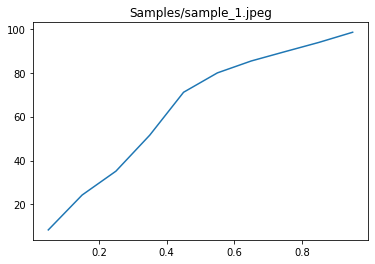

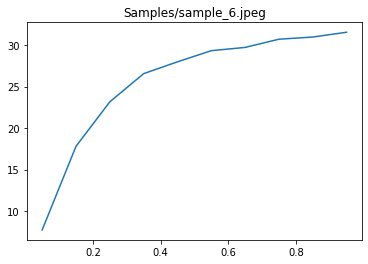

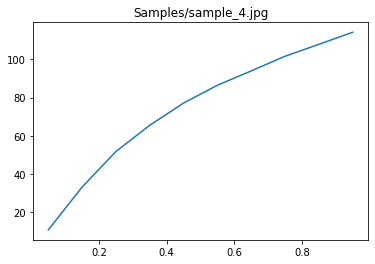

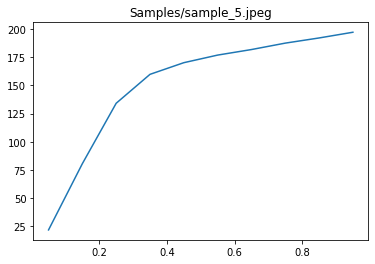

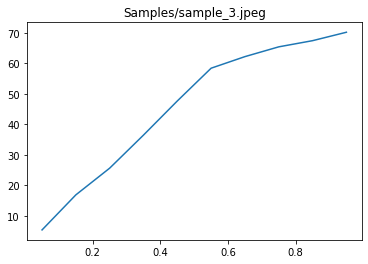

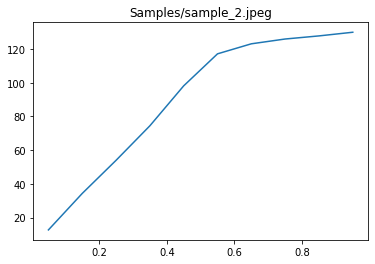

In [103]:

for fname in os.listdir('Samples'):
    fabricDiagnosis('Samples/' + fname,block_size=1)

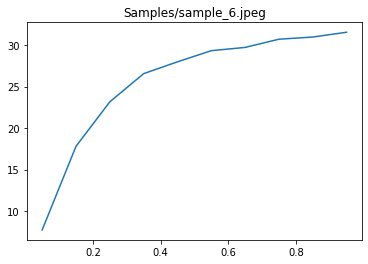

In [89]:
arr = fabricDiagnosis('Samples/sample_6.jpeg')


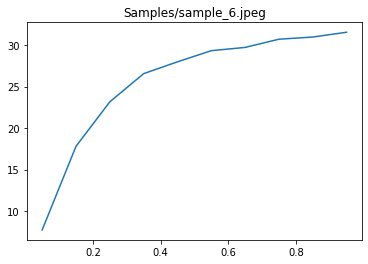

[7.71875, 17.791666666666668, 23.15625, 26.553571428571427, 27.979166666666668, 29.323863636363637, 29.716346153846153, 30.70625, 30.966911764705884, 31.54605263157895]
[10.072916666666668, 5.364583333333332, 3.397321428571427, 1.4255952380952408, 1.3446969696969688, 0.3924825174825166, 0.9899038461538474, 0.2606617647058833, 0.5791408668730647]
[0.46742502585315426, 0.36671289875173385, 0.5803766973280761, 0.05674701081799442, 0.7081256771397622, 1.5221603563474475, 0.7366797131674422, 1.2218098136738083]
29.323863636363637


In [112]:
arr = fabricDiagnosis('Samples/sample_6.jpeg')
print(arr)
print(fabricEstimate(arr))

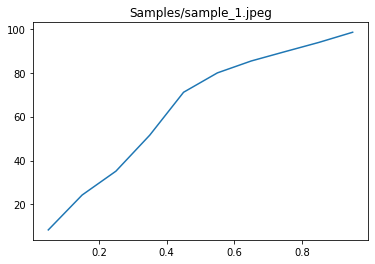

[15.876911314984708, 10.871257183183793, 16.38634593752704, 19.53138770497725, 8.81968683175829, 5.415540971071749, 4.255732801595215, 4.1963247211364205, 4.633044417823513]
[0.31527883682744723, 0.5073091972172512, 0.1919306341658283, 0.548435217969139, 0.3859712851060372, 0.21416293878522816, 0.013959541923432357, 0.10407195002984006]
51.55118110236221


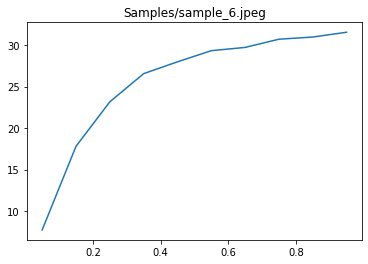

[10.072916666666668, 5.364583333333332, 3.397321428571427, 1.4255952380952408, 1.3446969696969688, 0.3924825174825166, 0.9899038461538474, 0.2606617647058833, 0.5791408668730647]
[0.46742502585315426, 0.36671289875173385, 0.5803766973280761, 0.05674701081799442, 0.7081256771397622, 1.5221603563474475, 0.7366797131674422, 1.2218098136738083]
29.323863636363637


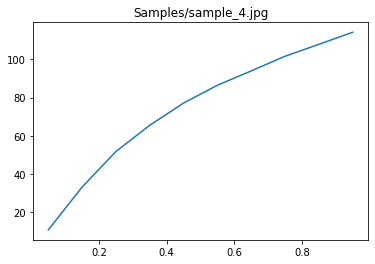

[22.476720647773284, 18.650082236842103, 13.74657654494382, 11.646018563751838, 9.32950310559005, 7.523666092943202, 7.682205260833911, 6.242285328250546, 6.3478881821990285]
[0.17024896429053932, 0.2629213978591314, 0.15280589856858556, 0.19891050709569782, 0.1935619713299443, 0.02107206326439845, 0.18743575362721565, 0.016917338505908843]
33.0921052631579


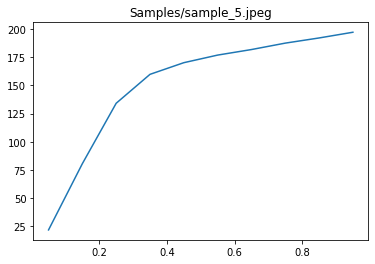

[58.69444444444444, 53.502222222222215, 25.620000000000005, 10.32592592592593, 6.728619528619532, 4.909557109557113, 5.689230769230761, 4.57803921568626, 5.061609907120754]
[0.08846190250828215, 0.5211413856122278, 0.5969583947726024, 0.3483761575583669, 0.2703470468682637, 0.15880733073781916, 0.19531490259705964, 0.10562834188435527]
134.16333333333333


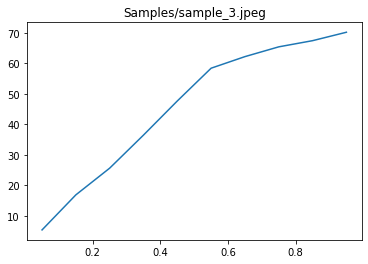

[11.492753623188406, 8.758328627893846, 10.84151034151034, 11.18558486544098, 10.743518794431914, 3.794970414201181, 3.2049783549783584, 2.022884240441485, 2.762069145194488]
[0.23792600841781167, 0.23785151278543035, 0.03173677034769188, 0.039521051096297576, 0.6467665308904178, 0.15546684027232727, 0.36883060776391907, 0.3654113715333901]
47.611510791366904


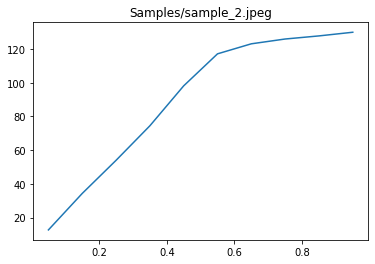

[21.63203463203463, 19.646611201298704, 20.47926850558659, 23.701232443437277, 18.982534685967252, 5.948708922065933, 2.8439846096096204, 1.841487068965506, 2.1731958275743892]
[0.0917816314788872, 0.0423817265866616, 0.1573280772685685, 0.199090818113832, 0.6866219911894333, 0.5219156548305393, 0.3524975266240003, 0.18013091929840566]
98.12581344902387


In [113]:
for fname in os.listdir('Samples'):
    print(fabricEstimate(fabricDiagnosis('Samples/' + fname,block_size=1)))

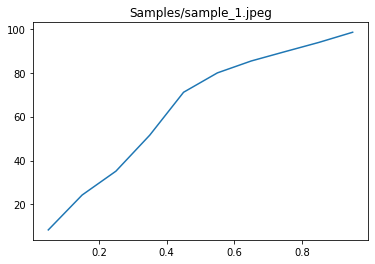

[15.876911314984708, 10.871257183183793, 16.38634593752704, 19.53138770497725, 8.81968683175829, 5.415540971071749, 4.255732801595215, 4.1963247211364205, 4.633044417823513]
[0.31527883682744723, 0.5073091972172512, 0.1919306341658283, 0.548435217969139, 0.3859712851060372, 0.21416293878522816, 0.013959541923432357, 0.10407195002984006]
71.08256880733946


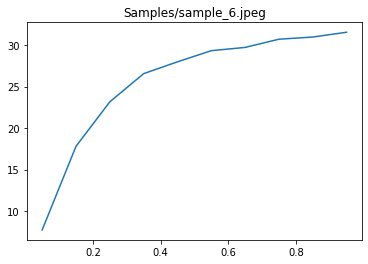

[10.072916666666668, 5.364583333333332, 3.397321428571427, 1.4255952380952408, 1.3446969696969688, 0.3924825174825166, 0.9899038461538474, 0.2606617647058833, 0.5791408668730647]
[0.46742502585315426, 0.36671289875173385, 0.5803766973280761, 0.05674701081799442, 0.7081256771397622, 1.5221603563474475, 0.7366797131674422, 1.2218098136738083]
29.716346153846153


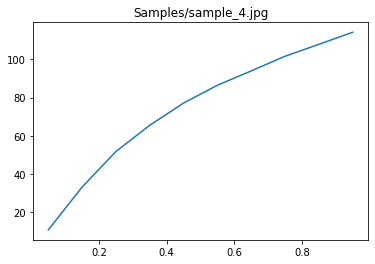

[22.476720647773284, 18.650082236842103, 13.74657654494382, 11.646018563751838, 9.32950310559005, 7.523666092943202, 7.682205260833911, 6.242285328250546, 6.3478881821990285]
[0.17024896429053932, 0.2629213978591314, 0.15280589856858556, 0.19891050709569782, 0.1935619713299443, 0.02107206326439845, 0.18743575362721565, 0.016917338505908843]
51.7421875


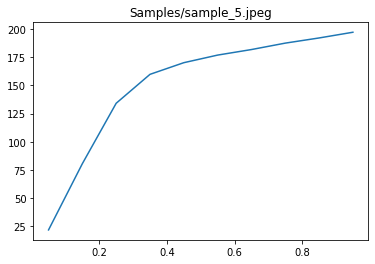

[58.69444444444444, 53.502222222222215, 25.620000000000005, 10.32592592592593, 6.728619528619532, 4.909557109557113, 5.689230769230761, 4.57803921568626, 5.061609907120754]
[0.08846190250828215, 0.5211413856122278, 0.5969583947726024, 0.3483761575583669, 0.2703470468682637, 0.15880733073781916, 0.19531490259705964, 0.10562834188435527]
159.78333333333333


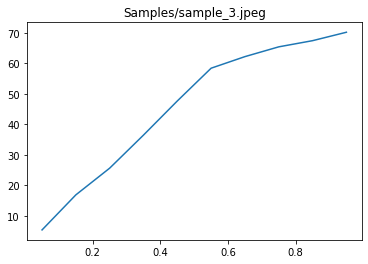

[11.492753623188406, 8.758328627893846, 10.84151034151034, 11.18558486544098, 10.743518794431914, 3.794970414201181, 3.2049783549783584, 2.022884240441485, 2.762069145194488]
[0.23792600841781167, 0.23785151278543035, 0.03173677034769188, 0.039521051096297576, 0.6467665308904178, 0.15546684027232727, 0.36883060776391907, 0.3654113715333901]
58.35502958579882


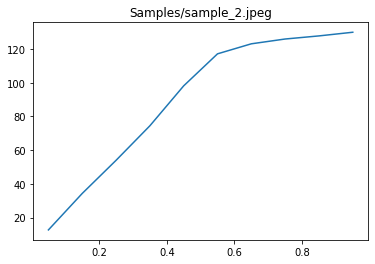

[21.63203463203463, 19.646611201298704, 20.47926850558659, 23.701232443437277, 18.982534685967252, 5.948708922065933, 2.8439846096096204, 1.841487068965506, 2.1731958275743892]
[0.0917816314788872, 0.0423817265866616, 0.1573280772685685, 0.199090818113832, 0.6866219911894333, 0.5219156548305393, 0.3524975266240003, 0.18013091929840566]
117.10834813499112


In [115]:
for fname in os.listdir('Samples'):
    print(fabricEstimate(fabricDiagnosis('Samples/' + fname,block_size=1)))